## Загрузим нужные библиотеки

In [3]:
!pip install catboost
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import make_scorer, f1_score

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV

%matplotlib inline

In [5]:
settlements = pd.read_csv("/content/settlements.csv")

In [6]:
settlements.shape

(155921, 14)

In [7]:
for col in settlements.columns:
    if settlements[col].dtype == 'O':
        settlements[col] = settlements[col].apply(str.lower)
settlements = settlements.sort_values('population', ascending=False)
settlements.reset_index(inplace=True)
settlements = settlements.iloc[:20000]

In [8]:
settlements.head(5)

,index,id,region,municipality,settlement,type,population,children,latitude_dms,longitude_dms,latitude_dd,longitude_dd,oktmo,dadata,rosstat
0,155604,155604,москва,южный,москва,г,1776789,276443,55.45.14,037.37.13,55.753889,37.620278,4.537800e+07,1,0
1,38743,38743,новосибирская область,новосибирск,новосибирск,г,1618039,311756,55.01.42,082.55.24,55.028333,82.923333,5.070100e+10,0,1
2,35772,35772,свердловская область,муниципальное образование «город екатеринбург»,екатеринбург,г,1515832,297019,56.50.19,060.36.20,56.838611,60.605556,6.570100e+10,0,1
3,148112,148112,москва,восточный,москва,г,1507198,229720,55.45.14,037.37.13,55.753889,37.620278,4.530400e+07,1,0
4,91315,91315,москва,юго-западный,москва,г,1427284,234537,55.45.14,037.37.13,55.753889,37.620278,4.500000e+07,1,0


In [9]:
obr_uch = pd.read_csv("/content/obr_uch.csv")

In [10]:
obr_uch.head()

,Abbr,Description
0,АУ,автономное учреждение
1,АУК,автономное учреждение культуры
2,БУ,бюджетное учреждение
3,БУК,бюджетное учреждение культуры
4,ГАОУ ВО,государственное автономное образовательное учр...


In [11]:
obr_uch['Abbr'] = obr_uch['Abbr'].apply(lambda s: ''.join(s.lower().split()))
obr_uch['len_Abbr'] = obr_uch['Abbr'].apply(lambda x: len(x))

obr_uch = obr_uch.sort_values('len_Abbr', ascending=False)

In [12]:
obr_uch.head()

,Abbr,Description,len_Abbr
47,фгбвоуво,федеральное государственное бюджетное военное ...,8
46,фгаоувпо,федеральное государственное автономное образов...,8
45,фгаоуво,федеральное государственное автономное образов...,7
66,фкоувпо,NaN,7
5,гаоудпо,государственное автономное образовательное учр...,7


In [13]:
data = pd.read_csv("/content/train_dataset_Altai.csv")
data.shape

(13584, 24)

## Рассмотрим датасет по ближе

In [14]:
data.head()

,ID,Код_группы,Год_Поступления,Пол,Основания,Изучаемый_Язык,Дата_Рождения,Уч_Заведение,Где_Находится_УЗ,Год_Окончания_УЗ,...,Общежитие,Наличие_Матери,Наличие_Отца,Страна_Родители,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
0,72716,16019,2015,Жен,ОО,Английский язык,1998-02-08 00:00:00.000,"МБОУ ""СОШ №59""","Алтайский край, Барнаул г",2014.0,...,0.0,0,0.0,Россия,0.0,0.0,0.0,41.0,4.294,3
1,63306,14895,2010,Муж,ЦН,NaN,1992-04-18 00:00:00.000,NaN,NaN,NaN,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,67.000,4
2,82469,20103,2017,Жен,ДН,Английский язык,1999-03-21 00:00:00.000,МБОУ Алтайская СОШ №5,"Алтайский край, Алтайский р-н, Алтайское с",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,41.0,4.133,4
3,81661,19838,2017,Жен,БН,Английский язык,1994-12-08 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,35.0,74.000,4
4,81509,19803,2017,Жен,БН,Английский язык,1995-06-28 00:00:00.000,ФГБОУ ВО Алтайский государственный университет,"Алтайский край, г. Барнаул",2017.0,...,0.0,1,1.0,Россия,0.0,0.0,0.0,28.0,53.000,4


In [15]:
for col in data.columns:
    if data[col].dtype == 'O':
        data[col] = data[col].fillna(data[col].mode()[0])
        data[col] = data[col].apply(str.lower)
    else:
        data[col] = data[col].fillna(-1)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                13584 non-null  int64  
 1   Код_группы        13584 non-null  int64  
 2   Год_Поступления   13584 non-null  int64  
 3   Пол               13584 non-null  object 
 4   Основания         13584 non-null  object 
 5   Изучаемый_Язык    13584 non-null  object 
 6   Дата_Рождения     13584 non-null  object 
 7   Уч_Заведение      13584 non-null  object 
 8   Где_Находится_УЗ  13584 non-null  object 
 9   Год_Окончания_УЗ  13584 non-null  float64
 10  Пособие           13584 non-null  float64
 11  Страна_ПП         13584 non-null  object 
 12  Регион_ПП         13584 non-null  object 
 13  Город_ПП          13584 non-null  object 
 14  Общежитие         13584 non-null  float64
 15  Наличие_Матери    13584 non-null  int64  
 16  Наличие_Отца      13584 non-null  float6

In [17]:
num_cols = []

cat_cols = []

target = 'Статус'

In [18]:
def lang(s):
    if 'англ' in s:
        return 'английский'
    if 'нем' in s:
        return 'немецкий'
    if 'фран' in s:
        return 'французский'
    if 'русc' in s:
        return 'русский'
    return 'unknown'

def unify_study(s):
    s = ''.join(c for c in s if c.isalpha() or c == ' ')
    s = ' '.join(s.split())
    s_abbr = ''.join(token[0] for token in s.split())
    s = ''.join(s.split())

    for abbr in obr_uch['Abbr']:
        if (abbr in s) or (abbr in s_abbr):
            return abbr
    
    return 'misprint'

In [19]:
for i in range(5):
    data[f'Код_группы_unigramm_{i}'] = data['Код_группы'].apply(lambda x: str(x)[i])
    cat_cols.append(f'Код_группы_unigramm_{i}')

for i in range(4):
    data[f'Код_группы_bigramm_{i}'] = data['Код_группы'].apply(lambda x: str(x)[i:i + 2])
    cat_cols.append(f'Код_группы_bigramm_{i}')

cat_cols.append('Код_группы')

In [20]:
data['Год_Поступления'] = data['Год_Поступления'].apply(lambda x: x if x != 2212 else 2012)
cat_cols.append('Год_Поступления')

In [21]:
cat_cols += ['Пол', 'Основания']

In [22]:
data['Год_рождения'] = data['Дата_Рождения'].apply(lambda x: x.split()[0].split('-')[0])
data['Месяц_рождения'] = data['Дата_Рождения'].apply(lambda x: x.split()[0].split('-')[1])
data['День_рождения'] = data['Дата_Рождения'].apply(lambda x: x.split()[0].split('-')[2])

cat_cols += ['Год_рождения', 'Месяц_рождения', 'День_рождения']

In [23]:
data['Уч_Заведение'] = data['Уч_Заведение'].apply(unify_study)

cat_cols.append('Уч_Заведение')

In [24]:
data['Год_Окончания_УЗ'] = data['Год_Окончания_УЗ'].apply(lambda x: str(int(x)))

cat_cols.append('Год_Окончания_УЗ')

In [25]:
cat_cols += ['Наличие_Матери', 'Наличие_Отца']

In [26]:
data['КодФакультета'] = data['КодФакультета'].apply(lambda x: str(int(x)))

for i in range(2):
    data[f'КодФакультета_unigramm_{i}'] = data['КодФакультета'].apply(lambda x: x[i])
    cat_cols.append(f'КодФакультета_unigramm_{i}')

cat_cols.append('КодФакультета')

In [27]:
ege_median = data['СрБаллАттестата'][(data['СрБаллАттестата'] <= 100) & (data['СрБаллАттестата'] > 29)].median()
data['СрБаллАттестата'] = data['СрБаллАттестата'].apply(lambda x: x if x <= 5 or 29 < x <= 100 else ege_median)

att_mean = data['СрБаллАттестата'][data['СрБаллАттестата'] <= 5].mean()
att_std = data['СрБаллАттестата'][data['СрБаллАттестата'] <= 5].std()

ege_mean = data['СрБаллАттестата'][data['СрБаллАттестата'] > 5].mean()
ege_std = data['СрБаллАттестата'][data['СрБаллАттестата'] > 5].std()

data['СрБаллАттестата'] = data['СрБаллАттестата'].apply(lambda x: (x - ege_mean) / ege_std if x > 5 else (x - att_mean) / att_std)
num_cols.append('СрБаллАттестата')

## Генерация новых фичей

In [28]:
years_fresh = []
years_grad = []
years_study = []
for birth_year, fresh_year, grad_year in zip(data['Год_рождения'], data['Год_Поступления'], data['Год_Окончания_УЗ']):
    birth_year = int(birth_year) if birth_year not in ['other', 'nan'] else -1
    fresh_year = int(fresh_year) if fresh_year not in ['other', 'nan'] else -1
    grad_year = int(grad_year) if grad_year not in ['other', 'nan'] else -1

    if birth_year != -1 and fresh_year != -1:
        years_fresh.append(fresh_year - birth_year)
    else:
        years_fresh.append(-1)

    if birth_year != -1 and grad_year != -1:
        years_grad.append(grad_year - birth_year)
    else:
        years_grad.append(-1)

    if grad_year != -1 and fresh_year != -1:
        years_study.append(fresh_year - grad_year)
    else:
        years_study.append(-1)

data['Лет_поступил'] = years_fresh
data['Лет_закончил'] = years_grad
data['Лет_ждал'] = years_study

data['Лет_ждал'] = data['Лет_ждал'].apply(lambda x: x if x > 0 else 0)
data['Лет_закончил'] = data['Лет_закончил'].replace(-1, data['Лет_закончил'][data['Лет_закончил'] > 0].median())

cat_cols += ['Лет_поступил', 'Лет_закончил', 'Лет_ждал']

## Стандартизация фичей

In [29]:
for col in cat_cols:
    data[col] = data[col].apply(str)

In [30]:
mean_num = dict()
std_num = dict()

for col in num_cols:
    data[col] = data[col].replace(-1, data[col][data[col] != -1].median())


num_cols_len = len(num_cols)

for col in num_cols:
    mean_num[col] = data[col].mean()
    std_num[col] = data[col].std()

    data[col] = (data[col] - mean_num[col]) / std_num[col]

## Визуально посмотрим на данные

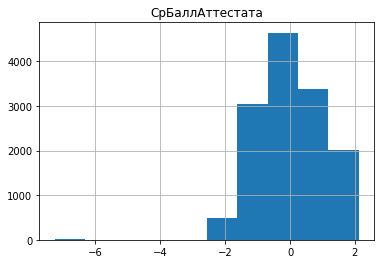

In [31]:
_ = data[num_cols].hist()

In [32]:
len(cat_cols)

26

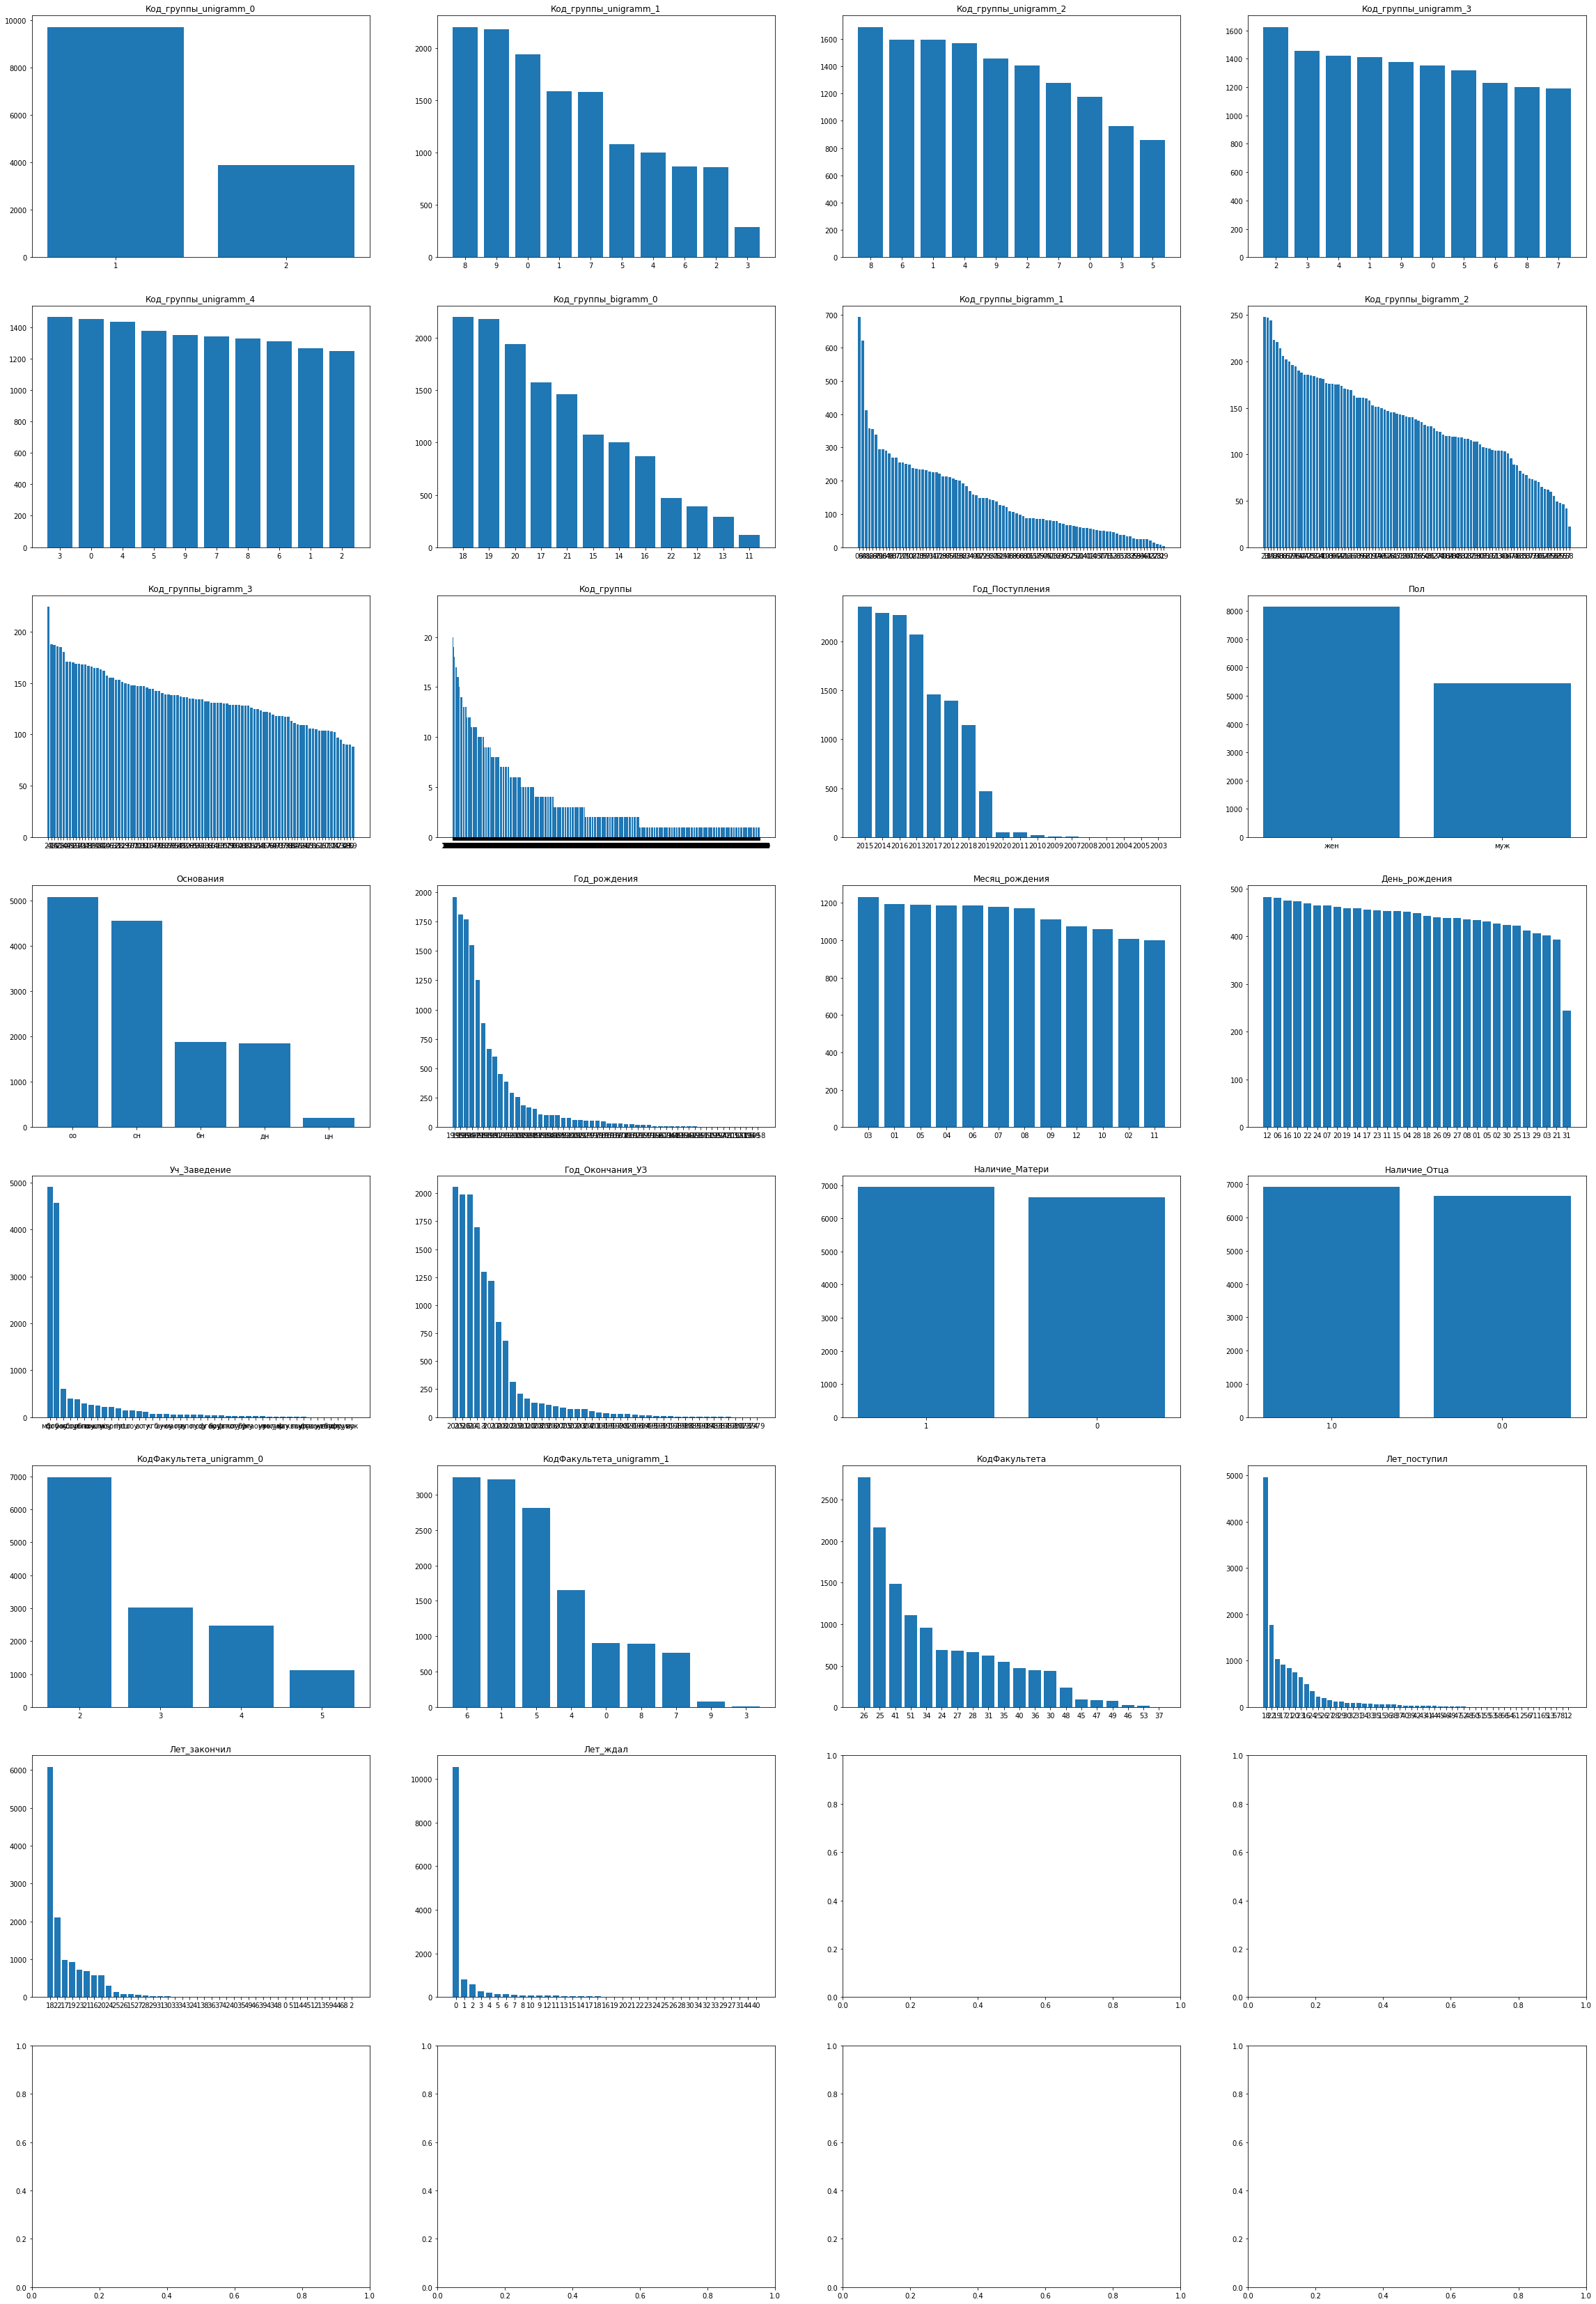

In [33]:
fig, axs = plt.subplots(8, 4, figsize=(40, 60))
for i, col in enumerate(cat_cols):
    vc = data[col].value_counts()
    labels = [k for k in vc.keys()]
    values = [vc[k] for k in labels]
    axs[i // 4, i % 4].bar(labels, values)
    axs[i // 4, i % 4].set_title(col)
plt.show()

## Выделим выборки

In [34]:
X = data[num_cols + cat_cols]
y = data[target]
X.shape, y.shape

((13584, 27), (13584,))

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

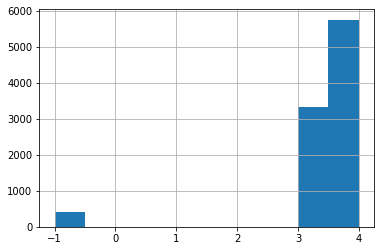

In [36]:
y_train.hist()

## Обучение модели

In [38]:
scorer = make_scorer(f1_score, average='macro', zero_division = 0)

cat_features = list(i for i, v in enumerate(X.columns) if v in cat_cols)
class_weights_sqrt = {i : (sum(y == 4) / sum(y == i)) ** .5 for i in sorted(y.unique())}
rcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)

param_grid={
            'loss_function':['MultiClass'],
            'task_type':['GPU'],
            'class_weights':[class_weights_sqrt],
            'cat_features':[cat_features],
            'iterations':[500],
            'grow_policy':['Lossguide'],
            'leaf_estimation_backtracking':['Armijo'],
            'boosting_type':['Plain'],
            'l2_leaf_reg':[5.93],
            'bootstrap_type':['Bayesian'],
            'depth':[8],
            'random_state':[42]
            }

boost_CV = HalvingGridSearchCV(
            CatBoostClassifier(),
            param_grid=param_grid,
            scoring=scorer,
            cv=rcv,
            # cv=5,
            verbose=2,
            n_jobs=-1
        )

boost_CV.fit(X, y)
model = boost_CV.best_estimator_
print(boost_CV.best_params_)
print(boost_CV.best_score_)

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 13584
max_resources_: 13584
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 13584
Fitting 25 folds for each of 1 candidates, totalling 25 fits
0:	learn: 1.0637923	total: 20.3ms	remaining: 10.1s
1:	learn: 1.0313865	total: 39.3ms	remaining: 9.79s
2:	learn: 0.9999453	total: 57.2ms	remaining: 9.48s
3:	learn: 0.9713956	total: 75.4ms	remaining: 9.35s
4:	learn: 0.9441835	total: 114ms	remaining: 11.2s
5:	learn: 0.9193820	total: 131ms	remaining: 10.8s
6:	learn: 0.8965488	total: 149ms	remaining: 10.5s
7:	learn: 0.8749705	total: 166ms	remaining: 10.2s
8:	learn: 0.8549611	total: 183ms	remaining: 9.99s
9:	learn: 0.8360549	total: 199ms	remaining: 9.76s
10:	learn: 0.8176128	total: 215ms	remaining: 9.57s
11:	learn: 0.8001367	total: 237ms	remaining: 9.64s
12:	learn: 0.7834884	total: 253ms	remaining: 9.49s
13:	learn: 0.7677088	total: 270ms	remaining: 9.37s
14:	learn: 0.7525720	total:

In [55]:
boost_CV.cv_results_['std_test_score'][0]

0.015575874822663167

# Cоздание файла с ответом

In [56]:
df_test = pd.read_csv("/content/test_dataset_Altai.csv")
df_submission = pd.read_csv("/content/sample_submission.csv")

In [57]:
for col in df_test.columns:
    if df_test[col].dtype == 'O':
        df_test[col] = df_test[col].fillna(df_test[col].mode()[0])
        df_test[col] = df_test[col].apply(str.lower)
    else:
        df_test[col] = df_test[col].fillna(-1)

Провем те же манипуляции с данными что и на обучении

In [58]:
for i in range(5):
    df_test[f'Код_группы_unigramm_{i}'] = df_test['Код_группы'].apply(lambda x: str(x)[i])

for i in range(4):
    df_test[f'Код_группы_bigramm_{i}'] = df_test['Код_группы'].apply(lambda x: str(x)[i:i + 2])

In [59]:
df_test['Год_рождения'] = df_test['Дата_Рождения'].apply(lambda x: x.split()[0].split('-')[0])
df_test['Месяц_рождения'] = df_test['Дата_Рождения'].apply(lambda x: x.split()[0].split('-')[1])
df_test['День_рождения'] = df_test['Дата_Рождения'].apply(lambda x: x.split()[0].split('-')[2])
df_test = df_test.drop(columns=['Дата_Рождения'])

In [60]:
df_test['Уч_Заведение'] = df_test['Уч_Заведение'].apply(unify_study)

In [61]:
df_test['Год_Окончания_УЗ'] = df_test['Год_Окончания_УЗ'].apply(lambda x: str(int(x)))

In [62]:
df_test['КодФакультета'] = df_test['КодФакультета'].apply(lambda x: str(int(x)))

for i in range(2):
    df_test[f'КодФакультета_unigramm_{i}'] = df_test['КодФакультета'].apply(lambda x: x[i])

In [63]:
df_test['СрБаллАттестата'] = df_test['СрБаллАттестата'].apply(lambda x: x if x <= 5 or 29 < x <= 100 else ege_median)
df_test['СрБаллАттестата'] = df_test['СрБаллАттестата'].apply(lambda x: (x - ege_mean) / ege_std if x > 5 else (x - att_mean) / att_std)

In [64]:
years_fresh = []
years_grad = []
years_study = []
for birth_year, fresh_year, grad_year in zip(df_test['Год_рождения'], df_test['Год_Поступления'], df_test['Год_Окончания_УЗ']):
    birth_year = int(birth_year) if birth_year not in ['other', 'nan'] else -1
    fresh_year = int(fresh_year) if fresh_year not in ['other', 'nan'] else -1
    grad_year = int(grad_year) if grad_year not in ['other', 'nan'] else -1

    if birth_year != -1 and fresh_year != -1:
        years_fresh.append(fresh_year - birth_year)
    else:
        years_fresh.append(-1)

    if birth_year != -1 and grad_year != -1:
        years_grad.append(grad_year - birth_year)
    else:
        years_grad.append(-1)

    if grad_year != -1 and fresh_year != -1:
        years_study.append(fresh_year - grad_year)
    else:
        years_study.append(-1)

df_test['Лет_поступил'] = years_fresh
df_test['Лет_закончил'] = years_grad
df_test['Лет_ждал'] = years_study
df_test['Лет_ждал'] = df_test['Лет_ждал'].apply(lambda x: x if x > 0 else 0)
df_test['Лет_закончил'] = df_test['Лет_закончил'].replace(-1, df_test['Лет_закончил'][df_test['Лет_закончил'] > 0].median())


In [65]:
for col in cat_cols:
    vc = df_test[col].value_counts()
    df_test[col] = df_test[col].apply(str)

In [66]:
for i in range(num_cols_len):
    df_test[num_cols[i]] = df_test[num_cols[i]].replace(-1, df_test[num_cols[i]][df_test[num_cols[i]] != -1].median())

for col in num_cols:
    df_test[col] = (df_test[col] - mean_num[col]) / std_num[col]

In [67]:
test_data = df_test[num_cols + cat_cols]

#Submit

In [68]:
df_test_pred = model.predict(test_data)

In [69]:
df_submission["Статус"] = df_test_pred
df_submission.head(4)

,ID,Статус
0,64996,4
1,71837,4
2,86587,3
3,73673,-1


In [70]:
df_submission.to_csv("/content/submission.csv", index=False)